# Runge-Kutta Methods

% TO DO
% - Improve the presentation of examples

**References:**

- Sections 6.4 *Runge-Kutta Methods and Applicaitons* in {cite}`Sauer`.
- Section 5.4 *Runge-Kutta Methods* in {cite}`Burden-Faires`.
- Sections 7.1 and 7.2 in {cite}`Chenney-Kincaid`.

In [1]:
using PyPlot

Introduction
------------

The original Runge-Kutta method is the fourth order accurate one to be described below, which is still used a lot, though with some modifications.

However, the name is now applied to a variety of methods based on a similar strategy, so first, here are a few simpler methods, all of some value, at least for small, low precision calculations.

## Euler's Method as a Runge-Kutta method

The simplest of all methods of this general form is Euler's method.
To set up the notation to be used below, rephrase it this way:

To get from $(t, u)$ to an approximation of $(t+h, u(t+h))$, use the approximation

$$\begin{split}
K_1 &= h f(t, u)
\\
u(t+h) &\approx u + K_1
\end{split}$$

## Second order Runge-Kutta methods

We have seen that the global error of Euler's method is $O(h)$: it is only first order accurate.
This is often insufficient, so it is more common even for small, low precision calculation to use one of several second order methods:

### The Explicit Trapezoid Method (a.k.a. the Improved Euler method or Huen's method)

One could try to adapt the trapezoid method for integrating $f(t)$ to solve $du/dt = f(t)$

$$
u(t + h) = u(t) + \int_{t}^{t + h} f(s) ds \approx u(t) + h \frac{f(t) + f(t+h)}{2}
$$

to solving the ODE $du/dt = f(t, u)$ but there is a problem that needs to be overcome:

we get

$$u(t + h) \approx u(t) + h \frac{f(t, u(t)) + h f(t+h, u(t+h))}{2}$$

and inserting the values $U_i \approx u(t_i)$ and so on gives

$$U_{i+1} = U_i + h \frac{f(t_i, U_i) + f(t_{i+1}, U_{i+1}))}{2}$$

This is known as the **Implicit Trapezoid Method**, because the value $U_{i+1}$ that we seek appears at the right-hand side too: we only have an *implicit* formula for it.

On one hand, one can in fact use this formula, by solving the equation at each time step for the unknown $U_{i+1}$;
for example, one can use methods seen in earlier sections such as fixed point iteration or the secant method.

We will return to this in a later section;
however, for now we get around this more simply by inserting an approximation at right — the only one we know so far, given by Euler's Method.
That is:

- replace $u(t+h)$ at right by the tangent line approximation $u(t+h) \approx u(t) + hf(t, u(t))$, giving

$$ u(t + h) \approx u(t) + h \frac{f(t, u(t)) + f(t+h, u(t) + hf(t, u(t)))}{2} $$

and for the formulas in terms of the $U_i$, replace $U_{i+1}$ at right by $U_{i+1} \approx U_i + h f(t_i, U_i)$, giving

$$ U_{i+1} = U_i + h \frac{f(t_i, U_i) + f(t_{i+1}, U_i + h f(t_i, U_i))}{2} $$

This is the **Explicit Trapezoid Method**.

It is convenient to break this down into two stages, one for each evaluation of $f(t, u)$:

$$\begin{split}
K_1 &= h f(t, u)
\\
K_2 &= h f(t+h, u + K_1)
\\
u(t+h) &\approx u + \frac{1}{2}(K_1 + K_2)
\end{split}$$

For equal sized time steps, this leads to

```{prf:algorithm} The Explicit Trapezoid Method
:label: explicit-trapezoid

$$\begin{split}
U_0 &= u_0
\\
U_{i+1} &= U_i + \frac{1}{2}(K_1 + K_2),
\\
&\quad \text{where}
\\
K_1 &= h f(t_i, U_i)
\\
K_2 &= h f(t_{i+1}, U_i + K_1)
\end{split}$$
```

We will see that, despite the mere first order accuracy of the Euler approximation used in getting $K_2$, this method is second order accurate; the key is the fact that any error in the approximation used for $f(t+h, u(t+h))$ gets multiplied by $h$.

See [Exercise 1](exercise-1).

In [2]:
function explicittrapezoid(f, a, b, u_0, n; demomode=false)
    # Use the Explict Trapezoid Method (a.k.a Improved Euler) to solve
    #     du/dt = f(t, u)
    # for t in [a, b], with initial value u(a) = u_0
    
    h = (b-a)/n
    t = range(a, b, n+1)  # Note: "n" counts steps, so there are n+1 values for t.
    u = zeros(n+1)
    u[1] = u_0
    for i in 1:n
        K_1 = f(t[i], u[i])*h
        K_2 = f(t[i]+h, u[i]+K_1)*h
        u[i+1] = u[i] + (K_1 + K_2)/2.0
    end
    return (t, u)
end;

As always, this function can now also be imported from module `NumericalMethods` with

    include("NumericalMethods.jl")
    using .NumericalMethods: explicitTrapezoid

### Examples

For all methods in this section, we will solve for versions of {prf:ref}`ode-simplest-genuine` and {prf:ref}`ode-stiff`
in {doc}`ODE-IVP-1-Euler`.

$$\frac{du}{dt} = f_1(t, u) = k u$$ (simplest-ode)

with general solution

$$u(t) = u_1(t; a, u_0, k) = u_0 e^{k(t-a)}$$ (simplest-ode-solution)

and

$$\frac{du}{dt} = f_2(t, u) = k(\cos(t) - u) - \sin(t)$$ (stiff-ode)

with general solution

$$u(t) = u_2(t; a, u_0, k) = \cos t + c e^{-k(t-a)}, \; c = u_0 - \cos(a)$$ (stiff-ode-solution)

For comparison to Euler's Method, the same examples are done with it [below](#euler-redux).

In [3]:
# A helper function for rounding some output to four significant digits
approx(x) = round(x, sigdigits=4);

````{prf:example}
:label: ode-simplest-genuine-solved

Let us first solve the simple ODE {eq}`simplest-ode` from {prf:ref}`ode-simplest-genuine`.
````

In [4]:
f1(t, u) = k*u
# The simplest "genuine" ODE, (not just integration):
# The solution is u(t) = u(t; a, u_0) = u_0 exp(t-a)
u1(t, u_0, k) = u_0 * exp(k*(t-a));

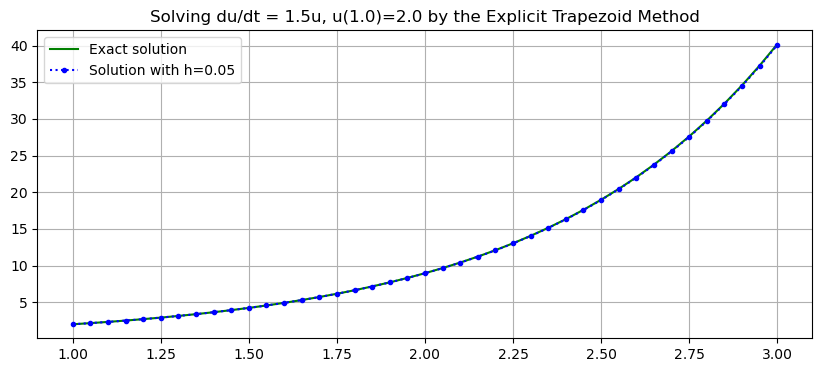

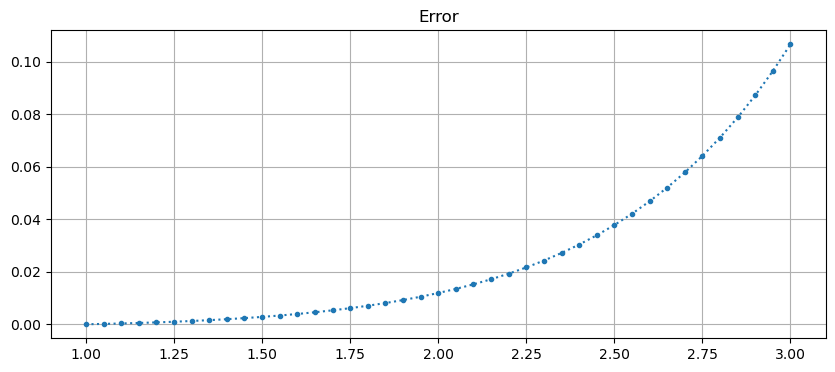

In [5]:
a = 1.0
b = 3.0
u_0 = 2.0
k = 1.5
n = 40

(t, U) = explicittrapezoid(f1, a, b, u_0, n; demomode=true)
u = u1.(t, u_0, k)
figure(figsize=[10,4])
title("Solving du/dt = $(k)u, u($a)=$u_0 by the Explicit Trapezoid Method")
plot(t, u, "g", label="Exact solution")
plot(t, U, ".:b", label="Solution with h=$(approx(b-a)/n)")
legend()
grid(true)

figure(figsize=[10,4])
title("Error")
plot(t, u - U, ".:")
grid(true)

````{prf:example}
:label: ode-stiff-solved

Solve the stiff ODE  {eq}`stiff-ode` from {prf:ref}`ode-stiff`.
````

In [6]:
f2(t, u) = k*(cos(t) - u) - sin(t)
# A simple more "generic" test case, with f(t, u) depending on both variables.
# The general solution is u(t) = u(t; a, u_0) = cos t + (u_0 - cos(a)) e^(k (a-t))
u2(t, a, u_0, k) = cos(t) + (u_0 - cos(a)) * exp(k*(a-t));

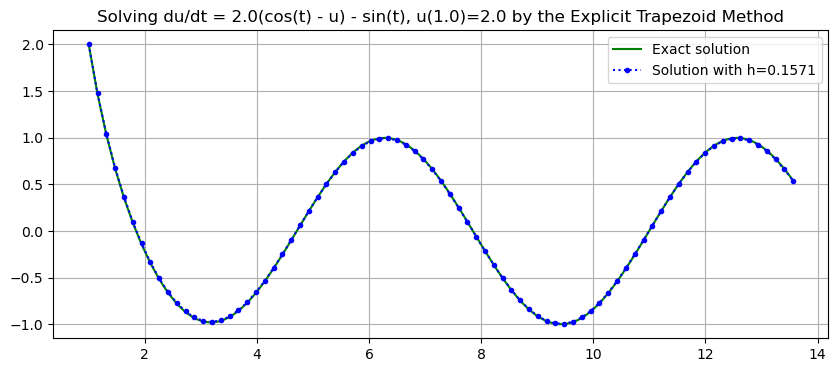

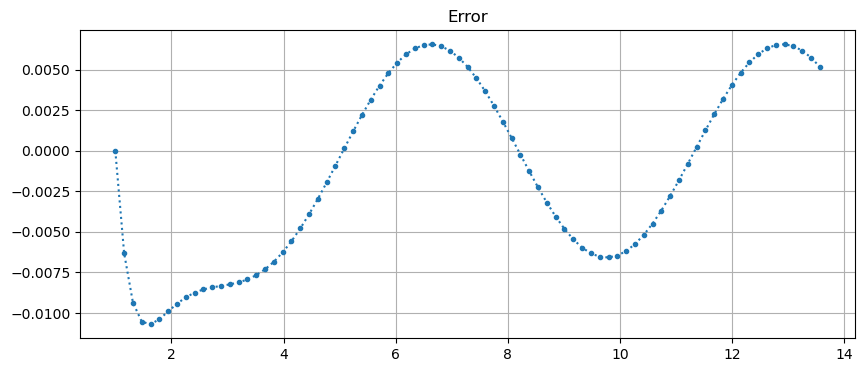

In [7]:
a = 1.0
b = a + 4pi  # Two periods
u_0 = 2.0
k = 2.0
n = 80

(t, U) = explicittrapezoid(f2, a, b, u_0, n)
u = u2.(t, a, u_0, k)
figure(figsize=[10,4])
title("Solving du/dt = $k(cos(t) - u) - sin(t), u($a)=$u_0 by the Explicit Trapezoid Method")
plot(t, u, "g", label="Exact solution")
plot(t, U, ".:b", label="Solution with h=$(approx((b-a)/n))")
legend()
grid(true)
    
figure(figsize=[10,4])
title("Error")
plot(t, u - U, ".:")
grid(true)

### The Explicit Midpoint Method (a.k.a. Modified Euler)

If we start with the Midpoint Rule for integration in place of the Trapezoid Rule, we similarly get an approximation

$$u(t + h) \approx u(t) + h f(t + h/2, u(t + h/2))$$

This has the slight extra complicatio that it involves three values of $u$ including $u(t+h/2)$ which we are not trying to evaluate.
We deal with that by making yet another approximation, using an average of $u$ values:

$$u(t+h/2) \approx \frac{u(t) + u(t+h)}{2}$$

leading to

$$u(t + h) \approx u(t) + h f\left( t + h/2, \frac{u(t) + u(t+h)}{2} \right)$$

and in terms of $U_i \approx u(t_i)$, the **Implicit Midpoint Method**

$$U_{i+1} = U_i + h f\left( t + h/2, \frac{U_i + U_{i+1}}{2} \right)$$

We will see in a later section that this is a particularly useful method in some situations, such as long-time solutions of ODEs that describe the motion of physical systems with conservation of momentum, angular momentum and kinetic energy. 

However, for now we again seek a more straightforward *explicit* method;
using the same tangent line approximation strategy as above gives

$$\begin{split}
K_1 &= h f(t, u)
\\
K_2 &= h f(t+h/2, u + K_1/2)
\\
u(t+h) &\approx u + K_2
\end{split}$$

and thus for equal-sized time steps

```{prf:algorithm} The Explicit Midpoint Method
:label: explicit-midpoint

$$\begin{split}
U_0 &= u_0
\\
U_{i+1} &= U_i + K_2
\\
&\quad \text{where}
\\
K_1 &= h f(t_i, U_i)
\\
K_2 &= h f(t_{i}+h/2, U_i + K_1/2)
\end{split}$$
```

See [Exercise 2](exercise-2) and [Exercise 3](exercise-3).

In [8]:
function explicitmidpoint(f, a, b, u_0, n; demomode=false)
    # Use the Explicit Midpoint Method (a.k.a Modified Euler) to solve
    #    du/dt = f(t, u) for t in [a, b], with initial value u(a) = u_0

    h = (b-a)/n
    t = range(a, b, n+1)  # Note: "n" counts steps, so there are n+1 values for t.
    u = zeros(length(t))
    u[1] = u_0
    for i in 1:n
        K_1 = f(t[i], u[i])*h
        K_2 = f(t[i]+h/2, u[i]+K_1/2)*h
        u[i+1] = u[i] + K_2
    end
    return (t, u)
end;

Again, available for import with

    include("NumericalMethods.jl")
    import .NumericalMethods: explicitmidpoint

### Examples

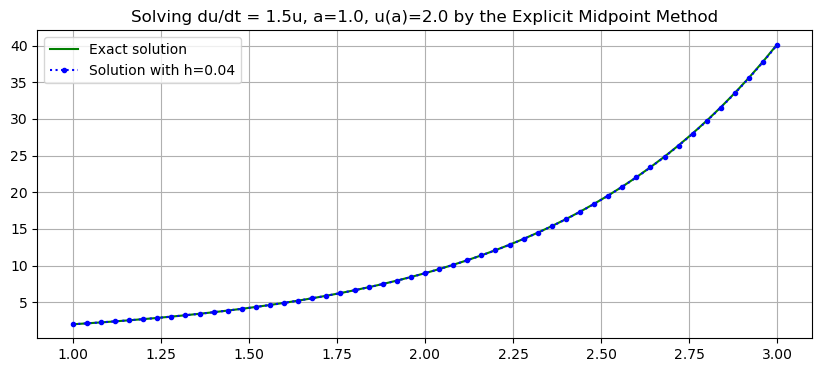

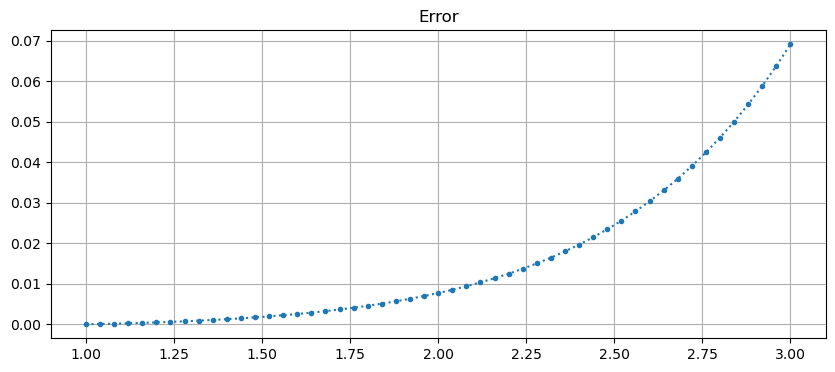

In [9]:
a = 1.0
b = 3.0
u_0 = 2.0
k = 1.5
n = 50

(t, U) = explicitmidpoint(f1, a, b, u_0, n; demomode=true)
u = u1.(t, u_0, k)
figure(figsize=[10,4])
title("Solving du/dt = $(k)u, a=$a, u(a)=$u_0 by the Explicit Midpoint Method")
plot(t, u, "g", label="Exact solution")
plot(t, U, ".:b", label="Solution with h=$(approx((b-a)/n))")
legend()
grid(true)
    
figure(figsize=[10,4])
title("Error")
plot(t, u - U, ".:")
grid(true)

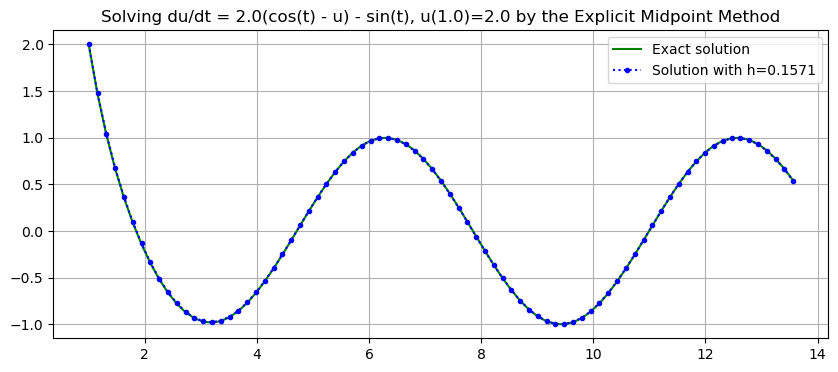

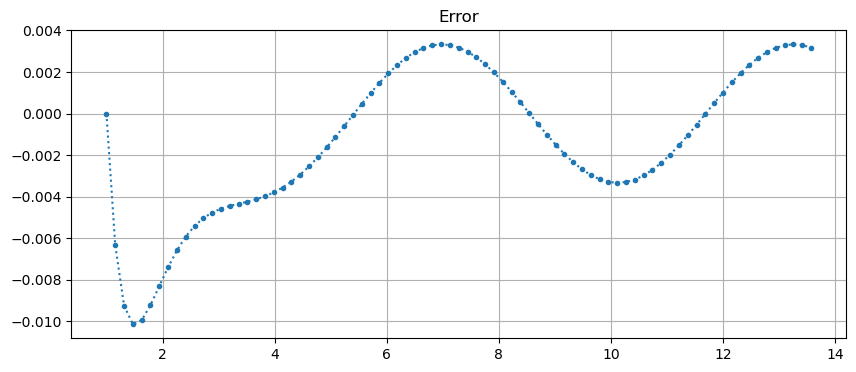

In [10]:
a = 1.0
b = a + 4pi  # Two periods
u_0 = 2.0
k = 2.0
n = 80

(t, U) = explicitmidpoint(f2, a, b, u_0, n)
u = u2.(t, a, u_0, k)
figure(figsize=[10,4])
title("Solving du/dt = $k(cos(t) - u) - sin(t), u($a)=$u_0 by the Explicit Midpoint Method")
plot(t, u, "g", label="Exact solution")
plot(t, U, ".:b", label="Solution with h=$(approx((b-a)/n))")
legend()
grid(true)
    
figure(figsize=[10,4])
title("Error")
plot(t, u - U, ".:")
grid(true)

## The "Classical", Fourth Order Accurate, Runge-Kutta Method

This is the original Runge-Kutta method:

```{prf:algorithm} The Runge-Kutta Method
:label: runge-kutta

$$\begin{split}
K_1 &= h f(t, u)
\\
K_2 &= h f(t + h/2, u + K_1/2)
\\
K_3 &= h f(t + h/2, u + K_2/2)
\\
K_4 &= h f(t + h, u + K_3)
\\
u(t+h) &\approx u + \frac{1}{6}(K_1 + 2 K_2 + 2 K_3 + K_4)
\end{split}$$
```

The derivation of this is far more complicated than those above, and is omitted.
For now, we will instead assess its accuracy "*a postiori*",
through the next exercise and some examples.

See [Exercise 4](#exercise-4).

In [11]:
function rungekutta(f, a, b, u_0, n; demomode=false)
    # Use the (classical) Runge-Kutta Method to solve
    #    du/dt = f(t, u) for t in [a, b], with initial value u(a) = u_0
    h = (b-a)/n
    t = range(a, b, n+1)  # Note: "n" counts steps, so there are n+1 values for t.
    u = zeros(length(t))
    u[1] = u_0
    for i in 1:n
        K_1 = f(t[i], u[i])*h
        K_2 = f(t[i]+h/2, u[i]+K_1/2)*h
        K_3 = f(t[i]+h/2, u[i]+K_2/2)*h
        K_4 = f(t[i]+h, u[i]+K_3)*h
        u[i+1] = u[i] + (K_1 + 2*K_2 + 2*K_3 + K_4)/6
    end
    return (t, u)
end;

Yet again, available for import with

    include("NumericalMethods.jl")
    import .NumericalMethods: rungekutta

### Examples

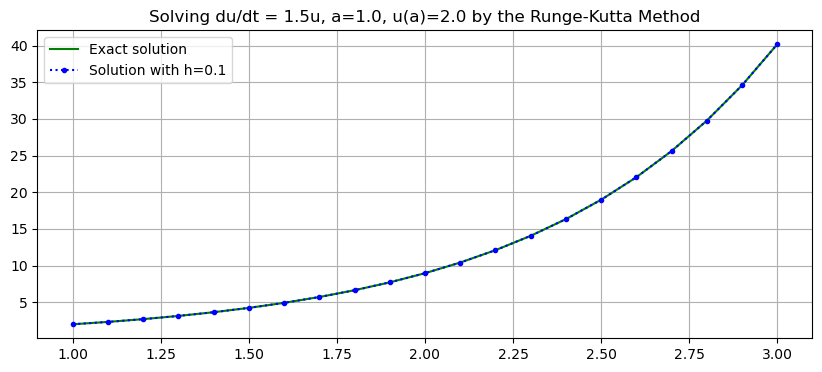

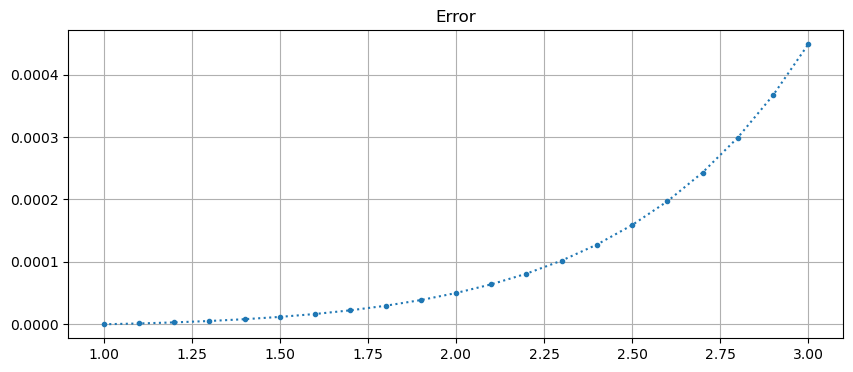

In [12]:
a = 1.0
b = 3.0
u_0 = 2.0
k = 1.5
n = 20

(t, U) = rungekutta(f1, a, b, u_0, n; demomode=true)
u = u1.(t, u_0, k)
h = round((b-a)/n, sigdigits=4)
figure(figsize=[10,4])
title("Solving du/dt = $(k)u, a=$a, u(a)=$u_0 by the Runge-Kutta Method")
plot(t, u, "g", label="Exact solution")
plot(t, U, ".:b", label="Solution with h=$(approx((b-a)/n))")
legend()
grid(true)
    
figure(figsize=[10,4])
title("Error")
plot(t, u - U, ".:")
grid(true)

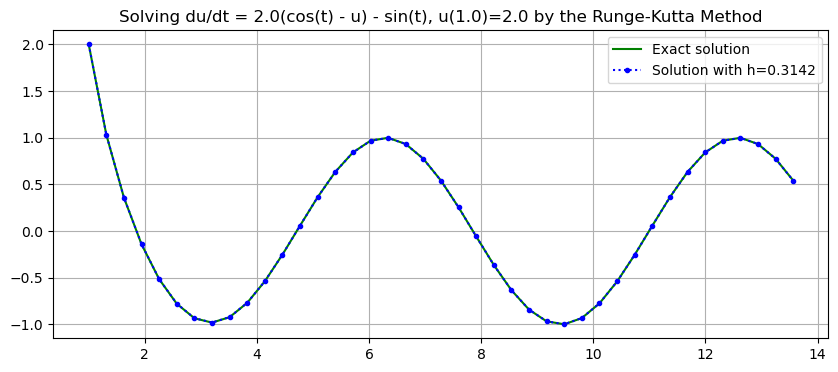

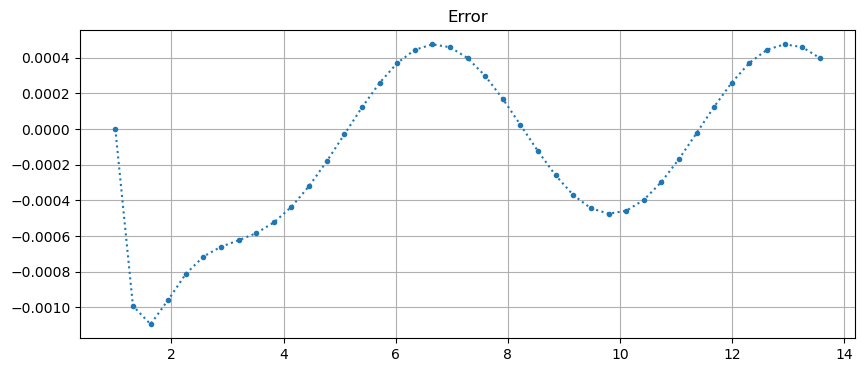

In [13]:
a = 1.0
b = a + 4pi  # Two periods
u_0 = 2.0
k = 2.0
n = 40

(t, U) = rungekutta(f2, a, b, u_0, n)
u = u2.(t, a, u_0, k)
figure(figsize=[10,4])
title("Solving du/dt = $k(cos(t) - u) - sin(t), u($a)=$u_0 by the Runge-Kutta Method")
plot(t, u, "g", label="Exact solution")
plot(t, U, ".:b", label="Solution with h=$(approx((b-a)/n))")
legend()
grid(true)
    
figure(figsize=[10,4])
title("Error")
plot(t, u - U, ".:")
grid(true)

<a name="euler-redux"></a>
## For comparison: the above examples done with Euler's Method

Since the (Explicit) Trapezoid and Midpoint methods do about twice as much work per step as Euler's method and the clasical Runge-Kutta method four time as much, a fair roughly equal cost comparions is done with
- 40 steps of Euler's method
- 20 steps of the Trapezoid and Midpoint methods
- 10 steps of the Runge-Kutta method

In [14]:
include("NumericalMethods.jl")
using .NumericalMethods: eulermethod

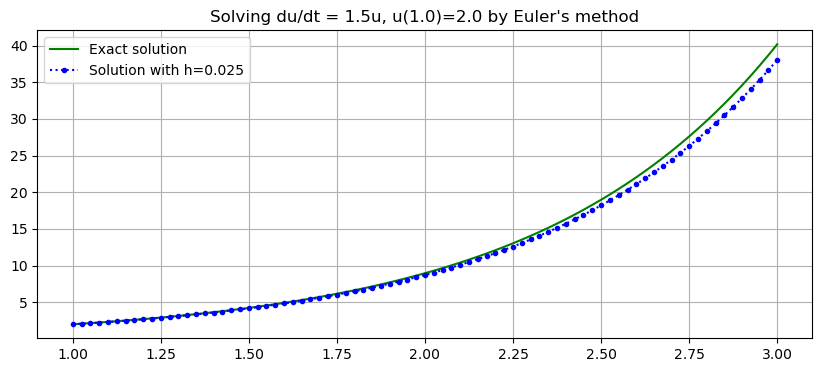

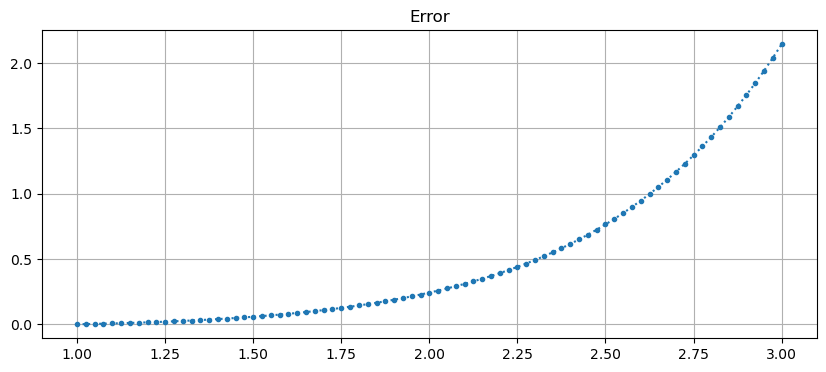

In [15]:
a = 1.0
b = 3.0
u_0 = 2.0
k = 1.5
n = 80

(t, U) = eulermethod(f1, a, b, u_0, n=n)
u = u1.(t, u_0, k)

figure(figsize=[10,4])
title("Solving du/dt = $(k)u, u($a)=$u_0 by Euler's method")
plot(t, u, "g", label="Exact solution")
plot(t, U, ".:b", label="Solution with h=$(approx((b-a)/n))")
legend()
grid(true)

figure(figsize=[10,4])
title("Error")
plot(t, u - U, ".:")
grid(true)

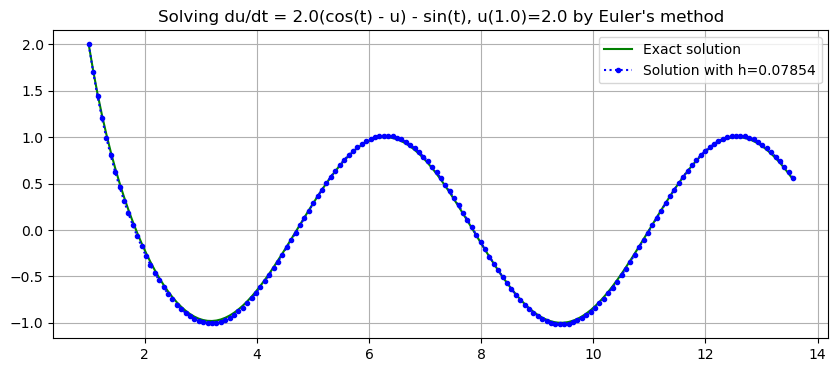

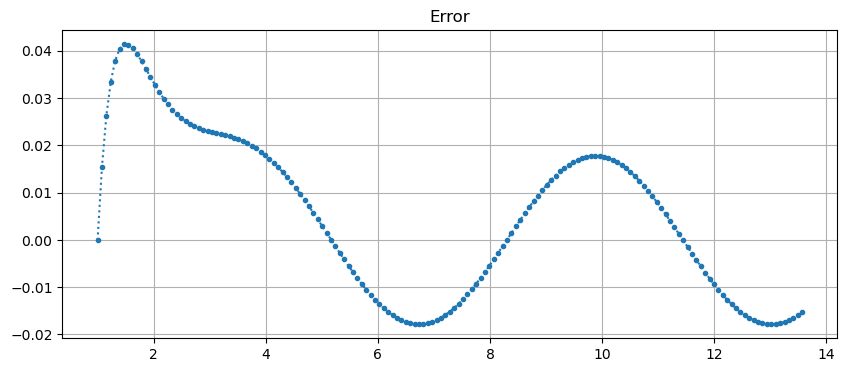

In [16]:
a = 1.0
b = a + 4pi  # Two periods
u_0 = 2.0
k = 2.0
n = 160

(t, U) = eulermethod(f2, a, b, u_0, n=n)
u = u2.(t, a, u_0, k)
h = round((b-a)/n, sigdigits=4)
figure(figsize=[10,4])
title("Solving du/dt = $k(cos(t) - u) - sin(t), u($a)=$u_0 by Euler's method")
plot(t, u, "g", label="Exact solution")
plot(t, U, ".:b", label="Solution with h=$(approx((b-a)/n))")
legend()
grid(true)
    
figure(figsize=[10,4])
title("Error")
plot(t, u - U, ".:")
grid(true)

---
## Exercises

<a name="exercise-1"></a>
### Exercise 1

A) Verify that for the simple case where $f(t, u) = f(t)$,
this gives the same result as the Composite Trapezoid Rule for integration.

B) Do one step of this method for the canonical example $du/dt = ku$, $u(t_0) = u_0$.
It will have the form $U_1 = G U_0$ where the growth factor $G$ approximates the factor $g=e^{kh}$ for the exact solution $u(t_1) = g u(t_0)$ of the ODE.

C) Compare to $G=1+kh$ seen for Euler's Method.

D) Use the previous result to express $U_i$ in terms of $U_0=u_0$, as done for Euler's Method.

<a name="exercise-2"></a>
### Exercise 2 (a lot like the previous)

A) Verify that for the simple case where $f(t, u) = f(t)$,
this give the same result as the Composite Midpoint rule for integration (same cooment as above).

B) Do one step of this method for the canonical example $du/dt = ku$, $u(t_0) = u_0$.
It will have the form $U_1 = G U_0$ where the growth factor $G$ approximates the factor $g=e^{kh}$ for the exact solution $u(t_1) = g u(t_0)$ of the ODE.

C) Compare to the growth factors $G$ seen for previous methods, and to the growth factor $g$ for the exact solution.

<a name="exercise-3"></a>
### Exercise 3

A) Apply Richardson extrapolation to one step of Euler's method, using the values given by step sizes $h$ and $h/2$.

B) This should give a second order accurate method, so compare it to the above two methods.

<a name="exercise-4"></a>
### Exercise 4

A) Verify that for the simple case where $f(t, u) = f(t)$,
this gives the same result as the Composite Simpson's Rule for integration.

B) Do one step of this method for the canonical example $du/dt = ku$, $u(t_0) = u_0$.
It will have the form $U_1 = G U_0$ where the growth factor $G$ approximates the factor $g=e^{kh}$ for the exact solution $u(t_1) = g u(t_0)$ of the ODE.

C) Compare to the growth factors $G$ seen for previous methods, and to the growth factor $g$ for the exact solution.